In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import pdb
from matplotlib.colors import ListedColormap
from utils import get_dataset, get_network, get_daparam, TensorDataset, epoch, ParamDiffAug

In [2]:
total_class_num = 100
selected_class_num = 1

In [3]:
model_teacher = models.resnet18(num_classes=100)
model_teacher.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model_teacher.maxpool = nn.Identity()
model_teacher = torch.nn.DataParallel(model_teacher).cuda()
checkpoint = torch.load('/root/SRE_repro/save/cifar100/cifar100_rn18_ep200/ckpt.pth')
model_teacher.load_state_dict(checkpoint["state_dict"])
model_teacher.eval()

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        

In [4]:
tsne = TSNE(n_components=2, random_state=42)


In [5]:
classes = np.random.choice(total_class_num, selected_class_num, replace=False)
classes

array([4])

#### load images from cifar100 dataset

In [6]:
from torchvision.datasets import CIFAR100
# add inception data augmentations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])
cifar100_dataset = CIFAR100(root='/root/SRE_repro/data', train=True, download=True, transform=transform)
cifar100_loader = DataLoader(cifar100_dataset, batch_size=100, shuffle=False)


print(classes)
train_loader = DataLoader(cifar100_dataset, batch_size=100, shuffle=False)
# calc mean and std on whole dataset
image_tensor = torch.stack([img for img, _ in train_loader.dataset])
print(image_tensor.shape)
mean = image_tensor.mean(dim=(0, 2, 3))
std = image_tensor.std(dim=(0, 2, 3))
print(mean, std)


Files already downloaded and verified
[4]
torch.Size([50000, 3, 32, 32])
tensor([ 0.0775,  0.0218, -0.0278]) tensor([1.3215, 1.2861, 1.3739])


In [7]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Resize((32, 32)),
#     transforms.Normalize(mean=mean, std=std)
# ])
flag = True
for ci in range(len(classes)):
    class_to_plot = classes[ci]
    print('class_to_plot:', class_to_plot)
    with torch.no_grad():
        for images, batch_labels in cifar100_loader:
            images = images.cuda()
            features_batch = model_teacher(images)
            labels_batch = batch_labels.cpu().numpy()
            class_indices = np.where(labels_batch == class_to_plot)[0]
            # print('class_indices:', class_indices)
            if len(class_indices) == 0:
                continue
            if flag:
                flag = False
                features_batch = features_batch[class_indices].squeeze().cpu().numpy()
                print(features_batch.shape)
                features = features_batch.reshape(-1, 100)
                # print('c', ci, 'total', features.shape)
            else:
                features_batch = features_batch[class_indices].cpu().numpy()
                features = np.concatenate((features, features_batch), axis=0)
                # print('c', ci, 'total', features.shape)
    print(features.shape)

class_to_plot: 4
(3, 100)
(500, 100)


In [8]:
features_flat = features.reshape(features.shape[0], -1)
features_flat.shape

(500, 100)

#### load sre2l distilled images

In [9]:
sre2l_train_dir = '/root/SRE_repro/syn_data/cifar100_rn18_1k_ipc50'
# read from the file
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])


train_dataset = datasets.ImageFolder(
    sre2l_train_dir,
    transform=transform
)
print(classes)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=False)
# calc mean and std on whole dataset
image_tensor = torch.stack([img for img, _ in train_loader.dataset])
mean = image_tensor.mean(dim=(0, 2, 3))
std = image_tensor.std(dim=(0, 2, 3))
print(mean, std)


[4]
tensor([-0.2690, -0.3329, -0.3521]) tensor([1.4680, 1.4352, 1.4399])


In [10]:
flag = True
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=False)
with torch.no_grad():
    for images, batch_labels in train_loader:
        if batch_labels[0].item() in classes:
            images = images.cuda()
            features_batch = model_teacher(images)
            features_batch = features_batch.cpu().numpy()
            if flag:
                flag = False
                features_batch = features_batch.squeeze().reshape(-1, 100)
                features = features_batch
                print(features.shape)
            else:
                features_batch = features_batch.squeeze().reshape(-1, 100)
                features = np.concatenate((features, features_batch), axis=0)
                print(features.shape)
            print('total', features.shape)

(50, 100)
total (50, 100)


In [11]:
sre2l_distill = features
sre2l_distill_flat = sre2l_distill.reshape(sre2l_distill.shape[0], -1)
sre2l_distill_flat.shape

(50, 100)

In [12]:
# features_flat_combined = np.concatenate((features_flat, our_distill_flat, sre2l_distill_flat), axis=0) 
features_flat_combined = np.concatenate((features_flat, sre2l_distill_flat), axis=0) 

In [13]:
print(features_flat_combined.shape)
print(features_flat.shape)
# print(our_distill_flat.shape)
print(sre2l_distill_flat.shape)

(550, 100)
(500, 100)
(50, 100)


In [14]:
embedded_data_combined = tsne.fit_transform(features_flat_combined)
# embedded_features_flat = tsne.fit_transform(features_flat)
# embedded_sre2l_distill_flat = tsne.fit_transform(sre2l_distill_flat)

In [15]:
classes

array([4])

In [16]:
colors = ['r', 'g', 'b', 'purple', 'orange']
# colors = ['r', 'purple', 'brown']

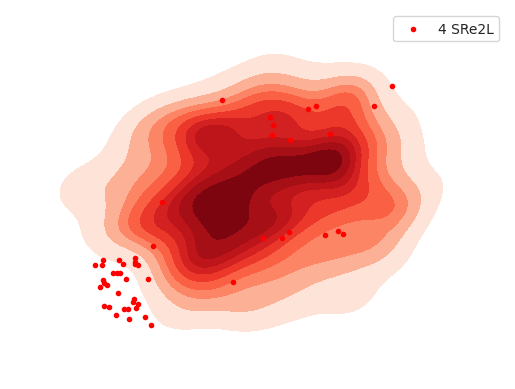

In [17]:
import seaborn as sns
import pandas as pd
sns.set_style("white")

x1 = embedded_data_combined[0 : 500, 0]
y1 = embedded_data_combined[0 : 500, 1]
# x2 = embedded_features_flat[500 : 1000, 0]
# y2 = embedded_features_flat[500 : 1000, 1]
# x3 = embedded_features_flat[1000 : 1500, 0]
# y3 = embedded_features_flat[1000 : 1500, 1]
# x4 = embedded_features_flat[1500 : 2000, 0]
# y4 = embedded_features_flat[1500 : 2000, 1]
# x5 = embedded_features_flat[2000 : 2500, 0]
# y5 = embedded_features_flat[2000 : 2500, 1]

df = pd.DataFrame({
    "x1": x1,
    "y1": y1,
    # "x2": x2,
    # "y2": y2,
    # "x3": x3,
    # "y3": y3,
    # "x4": x4,
    # "y4": y4,
    # "x5": x5,
    # "y5": y5,
})
sns.kdeplot(x=df.x1, y=df.y1, cmap="Reds", fill=True, bw_adjust=0.8)
# sns.kdeplot(x=df.x2, y=df.y2, cmap="Greens", fill=True, bw_adjust=0.8)
# sns.kdeplot(x=df.x3, y=df.y3, cmap="Blues", fill=True, bw_adjust=0.8)
# sns.kdeplot(x=df.x4, y=df.y4, cmap="Purples", fill=True, bw_adjust=0.8)
# sns.kdeplot(x=df.x5, y=df.y5, cmap="Oranges", fill=True, bw_adjust=0.8)

base = selected_class_num * 500
# base = 0

# for i in range(selected_class_num):
#     plt.scatter(
#         embedded_data_combined[i * 100 + base : (i+1) * 100 + base, 0], 
#         embedded_data_combined[i * 100 + base : (i+1) * 100 + base, 1], 
#         label='ours', 
#         marker='*', 
#         c=colors[i]
#     )
# base += selected_class_num * 100

for i in range(selected_class_num):
    plt.scatter(
        embedded_data_combined[i * 50 + base : (i+1) * 50 + base, 0], 
        embedded_data_combined[i * 50 + base : (i+1) * 50 + base, 1], 
        label=str(classes[i])+' SRe2L', 
        marker='.', 
        c=colors[i]
    )
# remove all axis
plt.axis('off')
plt.legend()
plt.show()